# Exploring the Fraud Detection Feature Set 
In the [previous notebook](./Data_Acquire_Clean.ipynb), we put together a dataframe of available merchant account information, with approximately **2.9%** of the observations identified as fraudulent cases, over roughly a 1.5 year period. Let's load this dataset and try to shed some additional light on the features to try to get healthy predictors of fraudulent merchants.

In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pytz
import us
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction import DictVectorizer as DV

%matplotlib inline

In [9]:
dat = pd.read_csv('./../data/train.csv')

In [15]:
dat.sample(5)

,merchantidentifier,IP_Address_organization,IP_Address_Location,Pierced_IP_address_organization,Pierced_IP_address_location,timezone_differencefromGMT_using_application_device,date_account_opened,state_from_application_address,AreaCodeState,first_transaction_time,first_transaction_amount,dateclosedforfraud,Flag_for_data_with_fraud_outcomes,is_fraud
107554,46746851,AT&T U-VERSE,TEXAS,AT&T U-VERSE,TEXAS,360.0,2014-05-14,TX,TX,2014-05-18 10:28:50,16.12,NaN,1,0
44767,37172957,CLEAR WIRELESS,CALIFORNIA,CLEAR WIRELESS,CALIFORNIA,480.0,2013-05-22,CA,CA,2013-07-05 22:58:13,17.72,NaN,1,0
111632,19887349063,TIME WARNER CABLE,HAWAII,TIME WARNER CABLE,HAWAII,600.0,2015-03-03,HI,HI,2015-03-24 18:23:28,2750.00,NaN,1,0
66549,19969429003,COMCAST CABLE,GEORGIA,COMCAST CABLE,GEORGIA,300.0,2014-06-30,GA,GA,2014-07-10 10:54:25,235.95,NaN,1,0
56008,40649489,COMCAST CABLE,COLORADO,COMCAST CABLE,COLORADO,420.0,2013-07-20,CO,CO,2013-07-26 20:21:46,0.50,NaN,1,0


## Feature Engineering  

Let's ask ourselves the following questions, and build some features if not already available:  
* Is there a correlation between the time taken from account open to first transaction, and fake merchants?  
* Is there anything peculiar about the first transaction amount distribution between normal and fake merchants?  
* How do the location variables interact with each other to identify fake merchants, if at all?  
    * Specifically, interactions between application IP location, pierced IP location, application device timezone, state on the application address, phone number driven location?  
* What can we learn about the merchants themselves? Do merchants with a large presence see more cases of fraud, after normalizing on the dataset? 

--- 

We start by creating a new feature, *time_to_first_txn* which captures the time taken between account open and first transaction.

In [37]:
dat['date_account_opened'] = pd.to_datetime(dat['date_account_opened'])
dat['first_transaction_time'] = pd.to_datetime(dat['first_transaction_time'])

#new feature
dat['time_to_first_txn'] = (dat['first_transaction_time'] - dat['date_account_opened']).apply(lambda date: date.days)

Let's now look at our numericals: time taken to first transaction, and transaction amount, and see how fraudulent cases behave...

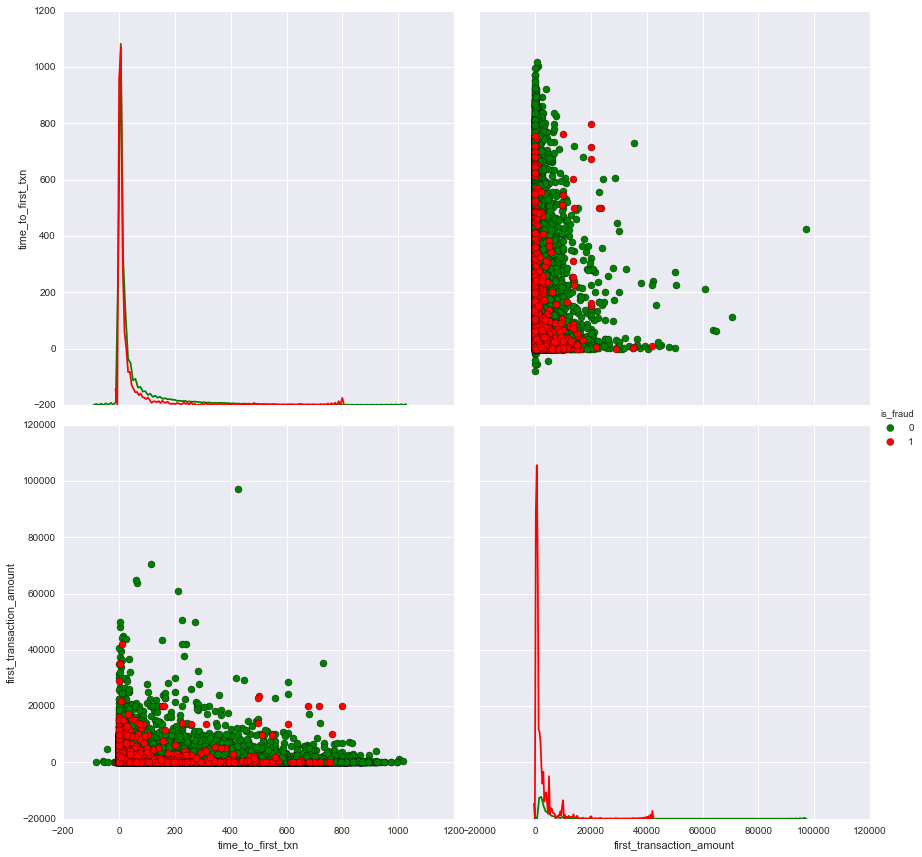

In [63]:
sns.pairplot(dat, vars=['time_to_first_txn','first_transaction_amount'], hue='is_fraud', 
             size=6, aspect=1, diag_kind='kde', plot_kws={'s':50, 'edgecolor':'black'},
            palette={0:'green',1:'red'})

Aha! We observe that while the # of days taken between account open and time to first transaction probably doesn't help discern much between fake and genuine merchants, the *first transaction amount* definitely does! Fraudulent merchants strongly tend to gravitate towards small first transaction amounts.  

> We also note (for later) that there are some seemingly erroneous data points in the dates recorded for account open versus first transaction dates because we see negative days. None of these data points are recorded as fraudulent, so we assume some sort of a data recording error for now. 

Let's take a closer look at the first transaction amount...

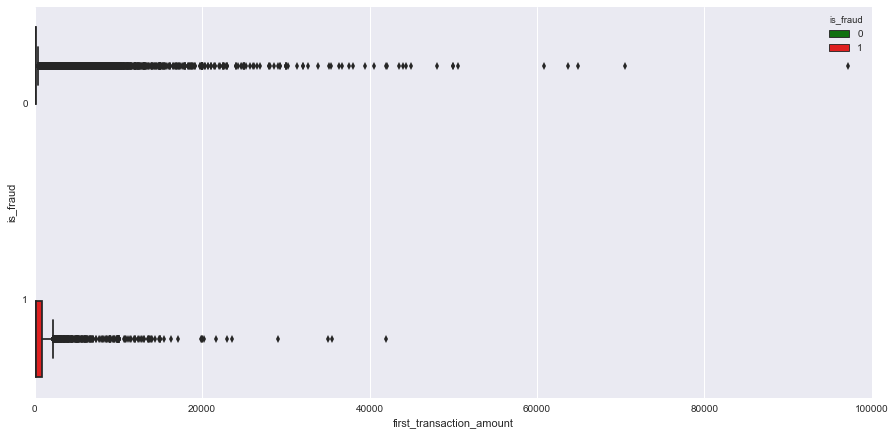

In [108]:
plt.figure(figsize=(15,7))
sns.boxplot(data=dat, y='is_fraud', x='first_transaction_amount',
            hue='is_fraud', palette={0:'green',1:'red'}, orient='h')

We notice that first transaction amounts tend to vary more for fraudulent merchants. Closer look...

[(0, 2500)]

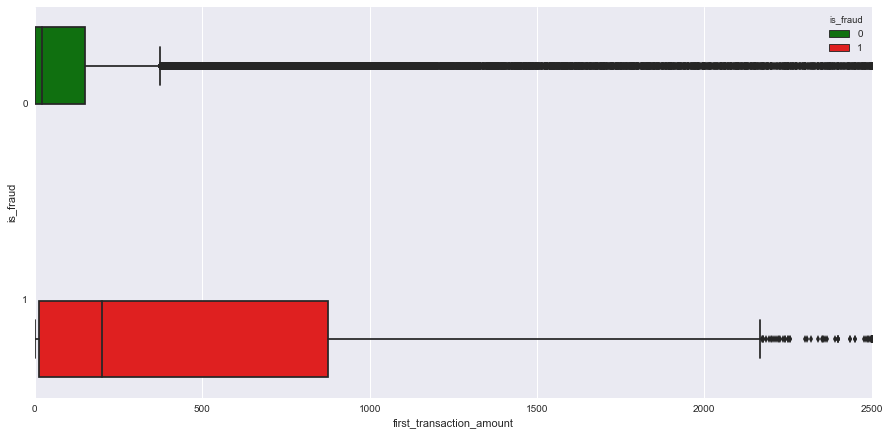

In [142]:
plt.figure(figsize=(15,7))
p=sns.boxplot(data=dat, y='is_fraud', x='first_transaction_amount',
            hue='is_fraud', palette={0:'green',1:'red'}, orient='h')
p.set(xlim=(0,2500))


### Creating a Similarity Measure of Location Variables (TBD: LOCATION ABBR FOR GMT OFFSET!!!) 

We have 5 types of location information available: application IP loc, application pierced IP loc, application device time-zone, application address driven state, application phone number area code driven state; 

In order to understand how fraudulent merchants behave in terms of these variables, let's create something called a location uniformity score. Ideally, we'd like to see similar location parameters as what's indicated on the application. However, this needn't be the norm (e.g. different phone number, creating account while traveling). So let's see if this can shed any light on fraudulent merchant behavior.

We'll create a location uniformity coefficient for each merchant by computing the *Jaccard Similarity Score* between the location values. This is to give us an idea of how uniformly dissimilar a merchant's location identity is from the assumed ideal of same location value as the application address across all parameters. 

*Note*: With more domain knowledge, it will be more ideal to assign weighted measures to severity of location dissimilarities per metric. For e.g. GMT offset different from application state is worse than pierced IP being different. 

In [483]:
def loc_hom_coeff(X, basis_col, loc_cols):
    """
    Takes in dataframe where the columns represent various location attributes, and computes the 
    Jaccard Similarity Coefficient for each row, while comparing it to a homogenous representation of the row as indicated
    by the location in the "state_from_application_address".
    It returns this similarity score (0 is dis-similar and 1 is the same) as the merchant's 
    location homogeneity coefficient, a floating point value. 
    
    The Jaccard similarity tests two sets for difference in membership by treating each element as unique within the set.
    """
    
    loc_len = len(loc_cols)+1
    #print loc_len
    
    #create a homogenous representation of location from the basis column, for each row
    loc_hom_vecs = list(X[basis_col].apply(lambda val: filter(None, ((val+'%')*loc_len).strip().split('%')) ))
    #print loc_hom_vecs
    
    loc_cols.append(basis_col)
    #print loc_cols
    #for each row in the location space, compute the Jaccard Similarity Coeff. against its homogenous loc. representation
    loc_vecs = map(list, X[loc_cols].values)
    #print loc_vecs
    
    scores = []
    for i in range(len(loc_vecs)):
        #print loc_hom_vecs[i], loc_vecs[i]
        scores.append(jaccard_similarity_score(loc_hom_vecs[i], loc_vecs[i]))
    
    
    return pd.Series(scores)
    
    
    

The function I wrote above *loc_hom_coeff()* takes in a target dataframe, computes the Jaccard Similarity Coefficient between the location variables I specify against a homogenous location signature (built from the *state_from_application_address* variable). It returns the dataframe with a new column: *loc_homg_coeff* that captures the merchant's location homegeneity signature, so to speak. 

Let's invoke this function to get our new feature.

In [511]:
basis_col = 'state_from_application_address_cd'
loc_cols = ['IP_Address_Location','Pierced_IP_address_location','AreaCodeState_cd']

#Change state abbreviations to complete names
dat['state_from_application_address_cd'] = dat['state_from_application_address'].apply(lambda abbr: str(us.states.lookup(unicode(abbr))).upper())
dat['AreaCodeState_cd'] = dat['AreaCodeState'].apply(lambda abbr: str(us.states.lookup(unicode(abbr))).upper())

dat['loc_hmg_coeff'] = loc_hom_coeff(dat, basis_col, loc_cols)

(0, 6)

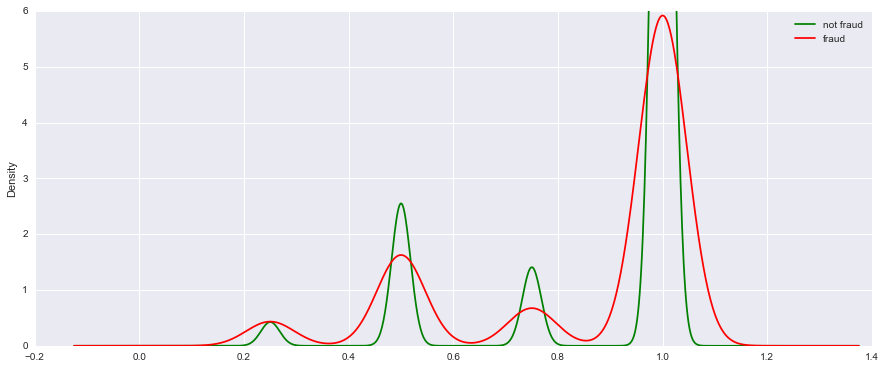

In [527]:
fig, ax = plt.subplots(figsize=(15,6))
dat[dat['is_fraud']==0]['loc_hmg_coeff'].plot(kind='kde', ax=ax, color='green', label='not fraud')
dat[dat['is_fraud']==1]['loc_hmg_coeff'].plot(kind='kde', ax=ax, color='red', label='fraud')
ax.legend()
ax.set_ylim(0,6) #zoomed in

The density plots of the location homogeneity coefficient indicate that _less similar_ location signatures tend to see higher densities of fraudulent merchants as compared to non-fraud merchants. This is indicated by the density of similarity scores in the 0.2-0.4 range for fraudulent merchants being about the same as that of non-fraudulent merchants.

It is conceivable that this distinction at lesser similarity measures might stand out with more data. This is also intuitive as too many differences from the application provided location tend to be less common for static businesses.

## Fraud Frequency by Organization 

In [543]:
#group by pierced firm name and # of subsidiary merchant applications
org_size = pd.DataFrame(dat.groupby(by='Pierced_IP_address_organization').size().sort_values(ascending=False), columns=['merchant_count'])

In [553]:
#group by perced firm name and sum of fraudulent merchants
org_frauds = pd.DataFrame(dat.groupby(by='Pierced_IP_address_organization')['is_fraud'].sum().sort_values(ascending=False))

In [556]:
org_stats = org_size.merge(org_frauds, how='inner', left_index=True, right_index=True)

In [594]:
org_stats['org_fraud_prevalence'] = org_stats['is_fraud']/org_stats['merchant_count']

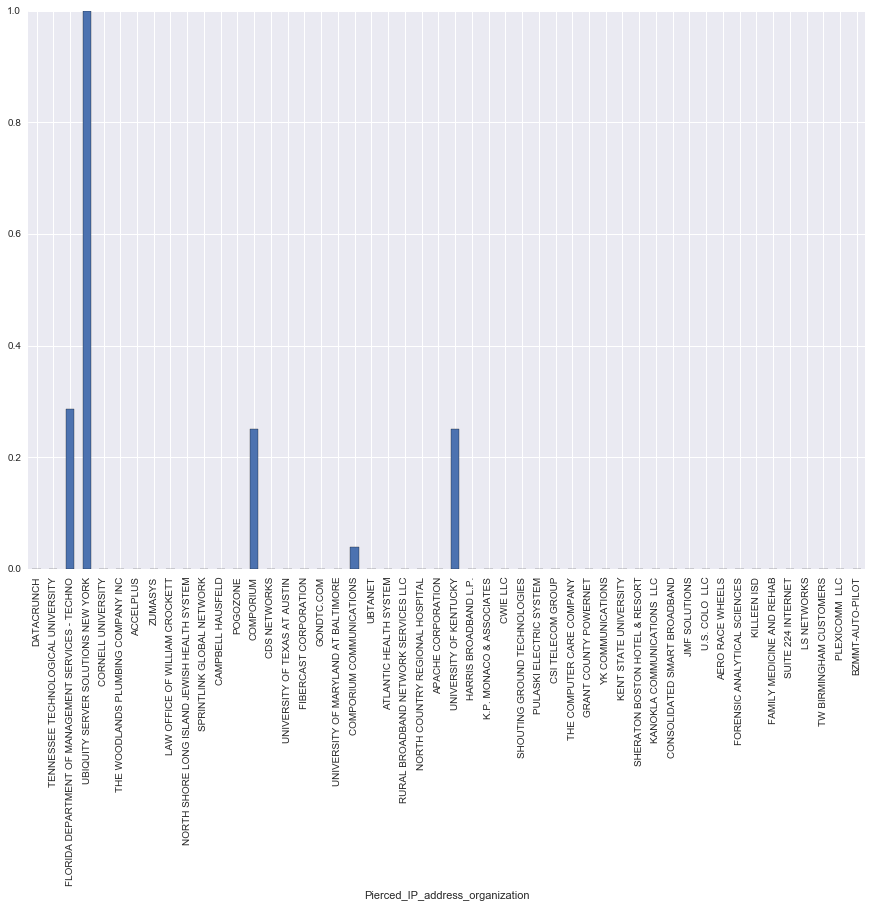

In [596]:
org_stats.sort_values(by='org_fraud_prevalence')['org_fraud_prevalence'].sample(50).plot(kind='bar', 
                                                                                                   figsize=(15,10))

Let's merge the Fraud Prevalence quotient back into the main dataset, to get our new feature that establishes a *prior* likelihood of fraud, given the organization.

In [598]:
dat = dat.merge(pd.DataFrame(org_stats['org_fraud_prevalence']), how='left', left_on='Pierced_IP_address_organization', right_index=True)

In [599]:
dat.sample(5)

,merchantidentifier,IP_Address_organization,IP_Address_Location,Pierced_IP_address_organization,Pierced_IP_address_location,timezone_differencefromGMT_using_application_device,date_account_opened,state_from_application_address,AreaCodeState,first_transaction_time,first_transaction_amount,dateclosedforfraud,Flag_for_data_with_fraud_outcomes,is_fraud,time_to_first_txn,loc_hmg_coeff,state_from_application_address_cd,AreaCodeState_cd,org_fraud_prevalence
80360,43078253,TIME WARNER CABLE,FLORIDA,TIME WARNER CABLE,FLORIDA,300.0,2013-10-15,FL,FL,2013-10-19 14:16:07,5.0,NaN,1,0,4,1.00,FLORIDA,FLORIDA,0.025276
313,30904855,AT&T WI-FI SERVICES,Unknown,AT&T WI-FI SERVICES,Unknown,300.0,2013-08-12,GA,GA,2013-08-12 08:54:46,20.0,NaN,1,0,0,0.50,GEORGIA,GEORGIA,0.101190
82066,44244787,TIME WARNER CABLE,OHIO,TIME WARNER CABLE,OHIO,300.0,2014-01-30,OH,OH,2014-02-09 11:32:23,20.0,NaN,1,0,10,1.00,OHIO,OHIO,0.025276
47021,37611705,NORTH CAROLINA RESEARCH AND EDUCATION NETWORK,NORTH CAROLINA,NORTH CAROLINA RESEARCH AND EDUCATION NETWORK,NORTH CAROLINA,300.0,2013-06-05,NC,MD,2013-08-30 06:55:29,50.0,NaN,1,0,86,0.75,NORTH CAROLINA,MARYLAND,0.062500
65176,19908425683,AT&T U-VERSE,CALIFORNIA,AT&T U-VERSE,CALIFORNIA,480.0,2015-02-25,CA,CA,2015-04-07 12:05:47,150.0,NaN,1,0,41,1.00,CALIFORNIA,CALIFORNIA,0.024117


### Prior Fraud Prevalence Correlations 

This new feature opens up a neat set of possible avenues. Let's look at known organization fraud prevalence's interactions with the location homogeneity score and with first transaction amounts...

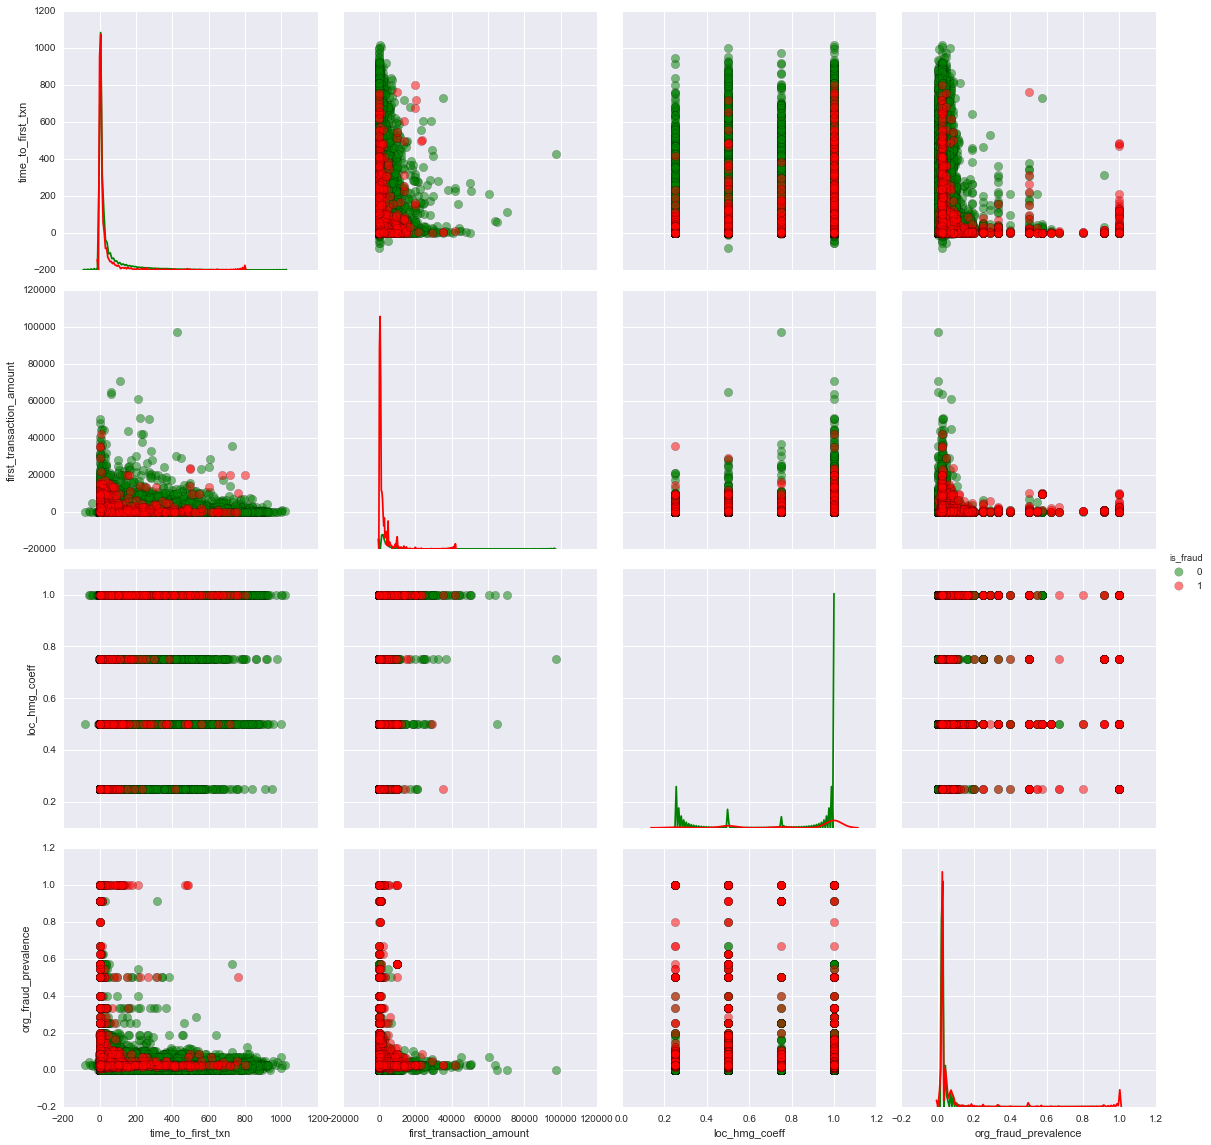

In [607]:
sns.pairplot(dat, vars=['time_to_first_txn','first_transaction_amount','loc_hmg_coeff','org_fraud_prevalence'], 
             hue='is_fraud', 
             size=4, aspect=1, diag_kind='kde', plot_kws={'s':70, 'edgecolor':'black', 'alpha':0.5},
            palette={0:'green',1:'red'})

We start to see that the more certain we are of the likelihood of an organization's merchant fraud history, we start to see some subtle correlations such as with time to first transaction (less than a year for strong likelihood of fraud), location homogeneity (less homogenous location variables). 

# Outliers and Unsupervised Clustering

So far, we haven't been able to get a very strong sense of outliers except for a few erroneous data points in the account open or time to first transaction dates. Let's see if there are any hidden clusters that can shed any light on the data. 

# WORK IN PROGRESS

Let's save our work so that we can move to the next phase: Addressing imbalance and training our models.

In [609]:
dat.to_csv('./../data/train.csv', index=False)

In [164]:
#first, build a dict of US states and timezone offsets
from geopy import geocoders # pip install geopy

g = geocoders.GoogleV3()
place, (lat, lng) = g.geocode('AL')

In [165]:
place

u'Alabama, USA'

## IP Time Zone Vs. Application Time Zone

We'd normally expect these two time zones to be the same, although this isn't a rule; but it would be concerning if there were vast differences in the IP time zone and the timezone registered from the registering device. Let's first map the timezones provided. 

In [ ]:
#code to track differnt locations:
#_ _ _ _ _; ip loc, pierced ip loc, app loc, area code loc, pierced ip Vs. device Time Zone; can have 16 different combinations here;
#fraud % by:
# location codes
# organization

#fraud by
# time to first transaction
# first trans amount
